In [1]:
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from util import preprocessing_util, audio_feature_util, clustering_util, image_util, autoencoder
from sklearn.decomposition import PCA

from tensorflow.keras.losses import MeanSquaredError

In [2]:
# Global
RANDOM_STATE = 42
AUDIO_PATH = pathlib.Path("../data/custom_data/audio_files")
MELSPECTROGRAM_PATH = pathlib.Path("../data/custom_data/autoencoder_based/melspectrograms")
MODEL_DATA_PATH = pathlib.Path("../data/custom_data/autoencoder_based/model")

# Stage 0: Preprocessing
AUDIO_DURATION = 45
DISCARD_SHORT_AUDIO = True
PERCENTAGE_FOR_TESTING = 5
PERCENTAGE_FOR_VALIDATION = 15

# Stage 1: Melspectrogram Dataset Generation
IMAGE_SHAPE = (368, 496)
BATCH_SIZE = 4

# Stage 2: Autoencoder
EPOCHS = 10
LATENT_DIM = 8

# Stage 3: Recommendation
CLUSTER_COUNT = 10


In [3]:
"""
STAGE 0: PREPROCESSING

Generate audio features and prepare data for autoencoder.
"""
features = audio_feature_util.load_audio_features(
  AUDIO_PATH, 
  max_duration=AUDIO_DURATION, 
  thread_pool_size=10, 
  discard_short_audio=DISCARD_SHORT_AUDIO,
  melspectrograms_save_path=MELSPECTROGRAM_PATH
)

preprocessing_util.split_model_resources(
  MELSPECTROGRAM_PATH, 
  MODEL_DATA_PATH,
  percentage_for_testing=PERCENTAGE_FOR_TESTING,
  percentage_for_validation=PERCENTAGE_FOR_VALIDATION
)
  
test_path = MODEL_DATA_PATH / "test"
train_path = MODEL_DATA_PATH / "train"
validation_path = MODEL_DATA_PATH / "validation"

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  2 out of 10 | elapsed:    7.1s remaining:   28.7s
[Parallel(n_jobs=10)]: Done 10 out of 10 | elapsed:   10.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  2 out of 10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 10 out of 10 | elapsed:    3.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  2 out of 10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=10)]: Done 10 out of 10 | elapsed:    2.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  2 out of 10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 10 out of 10 | elapsed:    3.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: 

In [4]:
"""
STAGE 1: MELSPECTROGRAM DATASET GENERATION

Load melspectrograms and prepair them for the autoencoder.
"""

# Load raw image data.
test_generator = image_util.load_image_dataset(test_path, image_size=IMAGE_SHAPE, normalize=True)
train_generator = image_util.load_image_dataset(train_path, image_size=IMAGE_SHAPE, normalize=True)
validation_generator = image_util.load_image_dataset(validation_path, image_size=IMAGE_SHAPE, normalize=True)


In [5]:
# Create and batch tensorflow datasets from raw image data
train_dataset = tf.data.Dataset.from_tensor_slices((train_generator[1], train_generator[1])).batch(BATCH_SIZE)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_generator[1], validation_generator[1])).batch(BATCH_SIZE)
#train_dataset = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), reshuffle_each_iteration=True)

In [6]:
"""
STAGE 2: AUTOENCODER

Train autoencoder to extract features from melspectrograms.
"""

# Train autoencoder
autoencoder = autoencoder.Autoencoder(LATENT_DIM, (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3))
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

autoencoder.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - loss: 0.0485 - val_loss: 0.0232
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - loss: 0.0157 - val_loss: 0.0163
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0126 - val_loss: 0.0146
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.0115 - val_loss: 0.0140
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0111 - val_loss: 0.0136
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0108 - val_loss: 0.0139
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0107 - val_loss: 0.0131
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.0104 - val_loss: 0.0134
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 0.0104 - val_loss: 0.0128
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 0.0102 - val_loss: 0.0127


In [7]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 368, 496, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 184, 248, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 184, 248, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 92, 124, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 92, 124, 8)     │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 46, 62, 8)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,680 (26.09 KB)

 Trainable params: 6,680 (26.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 62, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 92, 124, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 92, 124, 16)    │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 184, 248, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 184, 248, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 368, 496, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 368, 496, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,259 (28.36 KB)

 Trainable params: 7,259 (28.36 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# outp = autoencoder.encoder.predict(test_generator_normalized)
# new_images = autoencoder.decoder.predict(outp)
# display(test_generator[0])

# for image in new_images:
#   ax = plt.imshow(image)
#   plt.show()

In [9]:
"""
STAGE 3: RECOMMENDATION

Extract features from melspectrograms using autoencoder, reduce it's dimensionality with PCA,
identify clusters with Kmeans, and use euclidean distance to find the best recommendation.
"""

# Get main features from encoder, and normalize to a range between -1 and 1
main_dataset = autoencoder.encoder.predict(train_generator[1])
main_dataset = main_dataset.reshape(main_dataset.shape[0], main_dataset.shape[1] * main_dataset.shape[2] * main_dataset.shape[3])
normalized_main_dataset = audio_feature_util.normalize(main_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


In [10]:
# Get input features from encoder, and normalize relative to the main features
test_dataset = autoencoder.encoder.predict(test_generator[1])
test_dataset = test_dataset.reshape(test_dataset.shape[0], test_dataset.shape[1] * test_dataset.shape[2] * test_dataset.shape[3])
normalized_test_dataset = audio_feature_util.normalize(test_dataset, relative_to=main_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


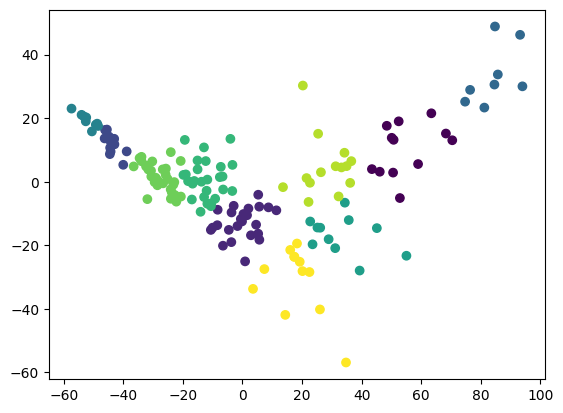

Input:         001 ANOTHER HIM.png
Best Match:    30 - The House (Trapped).png
----------------------------------
Input:         002 Beginning.png
Best Match:    150 The Third Sanctuary.png
----------------------------------
Input:         003 School.png
Best Match:    41 - Credits.png
----------------------------------
Input:         008 The Legend.png
Best Match:    092 Sandy Board.png
----------------------------------
Input:         009 Lancer.png
Best Match:    120 SWORD.png
----------------------------------
Input:         010 Rude Buster.png
Best Match:    098 Ruder Buster.png
----------------------------------
Input:         011 Empty Town.png
Best Match:    toby fox - UNDERTALE Soundtrack - 34 Memory.png
----------------------------------
Input:         013 Field of Hopes and Dreams.png
Best Match:    toby fox - UNDERTALE Soundtrack - 65 CORE.png
----------------------------------
Input:         015 Lantern.png
Best Match:    toby fox - UNDERTALE Soundtrack - 65 CORE.png
-----

In [11]:
# Apply PCA for dimensional reduction.
pca = PCA(n_components=2, random_state=RANDOM_STATE)
main_dataset_pca = pd.DataFrame(pca.fit_transform(normalized_main_dataset), columns=["pca1", "pca2"])
test_dataset_pca = pd.DataFrame(pca.transform(normalized_test_dataset), columns=["pca1", "pca2"])

# Cluster with Kmeans, then find closest clusters to the testing data.
clusters_pca, centroids_pca = clustering_util.kmeans_clustering(main_dataset_pca, n_clusters=CLUSTER_COUNT, random_state=RANDOM_STATE)
allocated_clusters = clustering_util.closest_clusters_euclidean(test_dataset_pca, centroids_pca)
clustering_util.plot_clusters(main_dataset_pca.values, clusters_pca)

# Add labels to datasets for identification.
main_dataset_pca.insert(loc=0, column="filename", value=train_generator[0])
test_dataset_pca.insert(loc=0, column="filename", value=test_generator[0])

# Loop through clusters and print out the best matching song for each row of testing data.
main_dataset_pca = main_dataset_pca.groupby(clusters_pca)
for i in range(len(allocated_clusters)):
  row = test_dataset_pca.drop("filename", axis=1).iloc[i]
  group = main_dataset_pca.get_group(allocated_clusters[i])
  
  closest_point = clustering_util.closest_points_euclidean([row], group.drop("filename", axis=1)).argmin()
  print("Input:         " + test_dataset_pca.iloc[i]["filename"])
  print("Best Match:    " + group.iloc[closest_point]["filename"])
  print("----------------------------------")
